In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from cars_detector.utils  import read_frame, read_test_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression_fast, box_otsu
from cars_detector.splitpictures import get_interest_areas, naive_window_sliding, pyramid, sliding_window

In [3]:
df_ground_truth = pd.read_csv('./train.csv')

## Sampling of positive and negative examples

In [4]:
total_positive_samples, total_negative_samples = sampling(df_ground_truth)

100%|██████████| 2225/2225 [02:48<00:00, 13.17it/s]


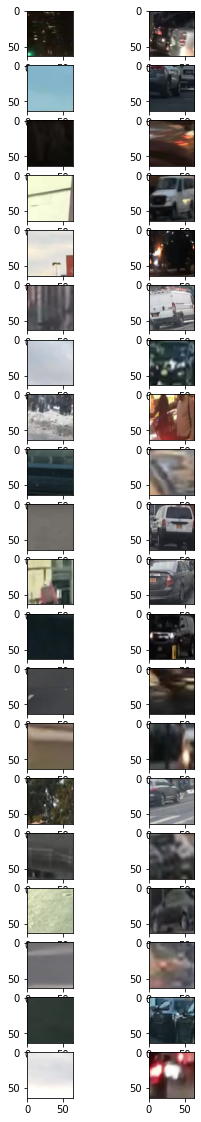

In [5]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)
fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]
        ax[i][j].imshow(img)

## Data Augmentation

In [6]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.1
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/21920 [00:00<?, ?it/s]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\skimage\_shared\utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 37906/37906 [00:02<00:00, 16806.12it/s]


In [7]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 24073
number of negative samples: 41699


## Features computation

In [4]:
if os.path.isfile("data/features/positive_features.npy") and os.path.isfile("data/features/negative_features.npy"):
    print('load data')
    positive_features = np.load("data/features/positive_features.npy")
    negative_features = np.load("data/features/negative_features.npy")
else:
    print('compute features')
    positive_features = []
    for img in tqdm(total_positive_samples, position = 0):
        feat = compute_features(img)
        positive_features.append(feat)
    np.save("data/features/positive_features.npy", positive_features)

    negative_features = []
    for img in tqdm(total_negative_samples, position = 0):
        feat = compute_features(img)
        negative_features.append(feat)
    np.save("data/features/negative_features.npy", negative_features)

load data


In [5]:
from sklearn.model_selection import train_test_split
X = np.concatenate((positive_features,negative_features), axis = 0)
y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [171]:
# creata weight matrix
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train))
w_array = np.zeros(y_train.shape[0])
w_array[y_train==1] = weight_ratio
w_array[y_train==0] = 1- weight_ratio


In [7]:
if os.path.isfile('data/models/XGBM.sav'):
    clf = pickle.load(open('data/models/XGB.sav', 'rb'))
else:
    clf = XGBClassifier()
    clf.fit(X_train, y_train, sample_weight=w_array)
    pickle.dump(clf, open('data/models/XGB.sav', 'wb'))


y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")


accuracy: 0.9074116305587229


In [ ]:
#do something with miss classif

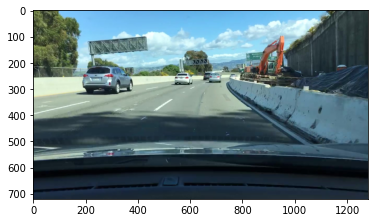

In [131]:
img = read_test_frame(10)
plt.imshow(img)

## Pyramid Window Sliding

In [133]:
# Define blocks and steps as above
pix_per_cell = 8
cell_per_block = 2
orient = 9
cells_per_step = 2
window = 64
scale_step=1.5
bboxes = []
pred_array = np.zeros((img.shape[0], img.shape[1]), dtype = float)
for i,test_img in enumerate(pyramid(img, scale=scale_step, minSize=(256, 256))):
    scale = scale_step**i
    nxblocks = (test_img.shape[1] // pix_per_cell)-1
    nyblocks = (test_img.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = feature.hog(test_img[:,:,0], orient, (pix_per_cell,pix_per_cell), (cell_per_block, cell_per_block), feature_vector=False)
    hog2 = feature.hog(test_img[:,:,1], orient, (pix_per_cell,pix_per_cell), (cell_per_block, cell_per_block), feature_vector=False)
    hog3 = feature.hog(test_img[:,:,2], orient, (pix_per_cell,pix_per_cell), (cell_per_block, cell_per_block), feature_vector=False)
 
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(test_img[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            color_features = compute_colors_features(subimg)
            features = np.concatenate((hog_features, color_features))

            # Scale features and make a prediction
            test_features = scaler.transform([features])
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = [ytop_draw,xbox_left, win_draw,win_draw]
                bboxes.append(box)
                pred_array[ytop_draw:ytop_draw+win_draw, xbox_left:xbox_left+win_draw] += 1
                


C:\Users\33631\AppData\Local\Temp\ipykernel_92540\211410285.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = np.int(xleft*scale)
C:\Users\33631\AppData\Local\Temp\ipykernel_92540\211410285.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

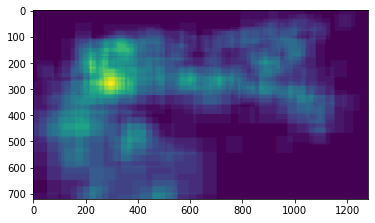

In [134]:
plt.imshow(pred_array)

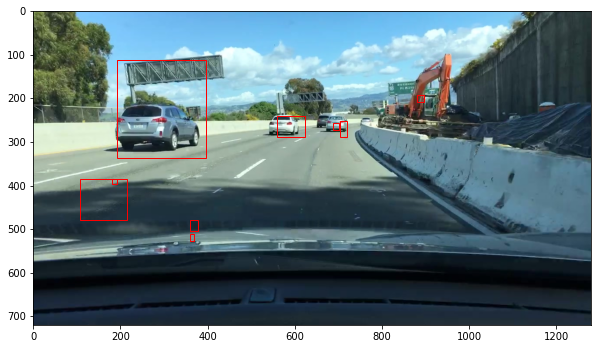

In [145]:
# method 1 with Ostsu thresholding

bbs = box_otsu(pred_array>15)

fig, ax = plt.subplots(figsize=(10, 8))
for x, y, dx, dy in bbs:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)

In [148]:
boxes_to_keep = []
means_list = []
threshold = 15
for box in bboxes:
    try:
        mean_pred = np.mean(pred_array[box[0]:box[0]+box[2], box[1]:box[1]+box[3]])
        means_list.append(mean_pred)
        if mean_pred > threshold:
            boxes_to_keep.append(box)
    except:
        continue

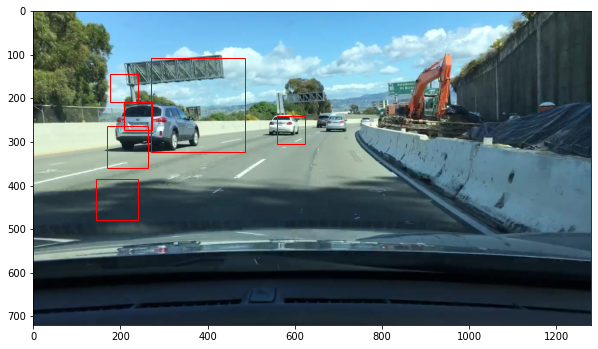

In [149]:
# method 2: non max supression 

new_boxes = non_max_suppression_fast(np.array(boxes_to_keep), 0.1)

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in new_boxes:
    rect = patches.Rectangle((y,x),dy,dx, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)
